# Manipulación de los datos.

In [2]:
#Bibliotecas externas
%matplotlib nbagg
from matplotlib import pyplot as plt, artist as art, patches as patches, animation
from mpl_toolkits.basemap import Basemap as Map
from matplotlib.path import Path 
from datetime import datetime
import matplotlib as mpl
import pandas as pd
import numpy as np

In [3]:
# Manejo de datos.
sismos=pd.read_csv("sismos-1993-2017.csv")
sismos = sismos[sismos['Ml']>=4.0]

In [4]:
# Se organizan los sismos por fechas.
fechas=[]
years=[]
meses=[]
for fecha in sismos["qdatetime"]:
    try:fechas.append(datetime.strptime(fecha,"%d/%m/%y %H:%M:%S"))
    except:fechas.append(datetime.strptime(fecha,"%d/%m/%Y %H:%M:%S"))
    years.append(fechas[-1].year)
    meses.append(fechas[-1].month)
sismos['fechas']=fechas
sismos['years']=years
sismos['mes']=meses
sismos=sismos.sort_values(['fechas'])

In [5]:
# Numero minimo y maximo de:

# Magnitud
nmin = sismos.Ml.min()
nmax = sismos.Ml.max()

# Longitud
xmin = sismos.qlon.min()
xmax = sismos.qlon.max()

# Latitud
ymin = sismos.qlat.min()
ymax = sismos.qlat.max()

# Profundidad
pmin = sismos.qdepth.min()
pmax = sismos.qdepth.max()

# 1. Creación de una gráfica animada en coordenadas polares.

In [6]:
#Mapa unitario
def x2u(x,a,b):
    u=(x-a)/(1.0*(b-a))
    return u
def u2x(u,a,b):
    x=u*(b-a)+a
    return x

<IPython.core.display.Javascript object>


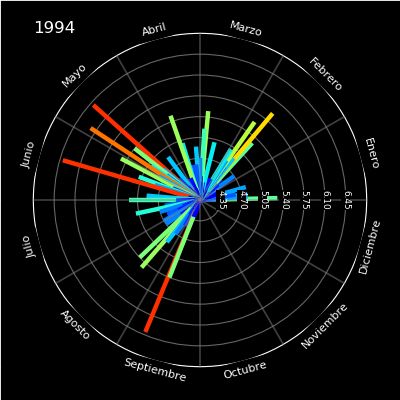

(-1.2, 1.2)

In [6]:
#Hoja de estilos
plt.style.use('dark_background')

#Espacio de graficación
fig=plt.figure(figsize=(5,5))
ax=fig.add_axes([0,0,1,1])

#Definimos los límites
ax.set_xlim((-1.2,1.2))
ax.set_ylim((-1.2,1.2))

In [7]:
#Circulo exterior
circulo=patches.Circle((0,0),radius=1)
circulo.set_edgecolor('white')
circulo.set_facecolor('none')
ax.add_patch(circulo)

In [8]:
#Divisiones radiales
n = 7
for i in range(n): 
    r=(i+1)/(n+1)
    divisiones = patches.Circle((0,0),radius=r)
    divisiones.set_edgecolor('white')
    divisiones.set_facecolor('none')
    divisiones.set_alpha(0.4)
    ax.add_patch(divisiones)
    #Marcas sobre las divisiones radiales
    ax.text(r,0,"%.2f"%u2x(r,nmin,nmax),
            ha='center',va='center',
            bbox=dict(facecolor='k',edgecolor='none',pad=0),
            rotation=-90,
            fontsize=8)

In [9]:
# Lineas de division y Etiquetas de meses.
Meses = ['Enero', 'Febrero', 'Marzo', 'Abril',
        'Mayo', 'Junio', 'Julio', 'Agosto',
        'Septiembre', 'Octubre', 'Noviembre',
        'Diciembre']
dB=30
for i in range(12):
    B=i*dB
    #Lineas
    x,y = np.cos(B*np.pi/180), np.sin(B*np.pi/180)
    linea=mpl.lines.Line2D([0,x], [0,y], color='gray', alpha=0.5)
    ax.add_line(linea)
    #Etiquetas
    ts=B+dB/2
    if B<=180:
        tt=ts-90
    else:
        tt=ts+90
    fac=1.06
    x,y = np.cos(ts*np.pi/180), np.sin(ts*np.pi/180)
    ax.text(fac*x,fac*y,"%s"%Meses[i],
            ha='center',va='center',rotation =tt, 
            bbox = dict(facecolor='k',edgecolor='none',pad=5))

In [10]:
#Objetos que se van a actualizar
texto=ax.text(-1,1,'', fontsize=15)

#Inicializacion
def init():
    pass

#Animacion
cmap=plt.get_cmap("jet")
def animacion(iframe):
    # Index sismo.
    pos = sismos.index[iframe]

    # Mes y anio del sismo.
    year = sismos.fechas[pos].year
    mes = sismos.fechas[pos].month
    
    # Texto
    texto.set_text(str(year))
        
    # Cantidad de sismos en un mes.
    Years = sismos[sismos.years==year]
    Meses = Years[Years.mes==mes]
    N = len(Meses)

    # Contador
    index_meses = Meses.index.values
    i = list(index_meses).index(pos)
        
    # Creacion de barras.
    teta = 30*(mes-1) + i*30/N
    radio=x2u(sismos.Ml[pos],nmin,nmax)
    x=radio*np.cos(teta*np.pi/180.)
    y=radio*np.sin(teta*np.pi/180.)

    # Color.
    valor_color=x2u(sismos.Ml[pos], nmin, nmax)
    color=cmap(valor_color)
    
    # Agregamos barras.
    barra=Path([(0,0),(x,y)],[Path.MOVETO, Path.LINETO])
    patch=patches.PathPatch(barra,facecolor='none', edgecolor=color, lw=4)
    ax.add_patch(patch)
    
    # Borramos los datos mas viejos
    if iframe!=0:
        year_new=year
        year_old=sismos.fechas[sismos.index[iframe-1]].year
        if year_new!=year_old:
            ax.patches=ax.patches[:8]
    
nframes=len(sismos)
anim=animation.FuncAnimation(fig,animacion, frames=nframes,
                             init_func=init, repeat=False)

In [11]:
anim.save('Figura1.gif', dpi=80, writer='imagemagick')

# 2. Mapa de Colombia representando los sismos.

<IPython.core.display.Javascript object>


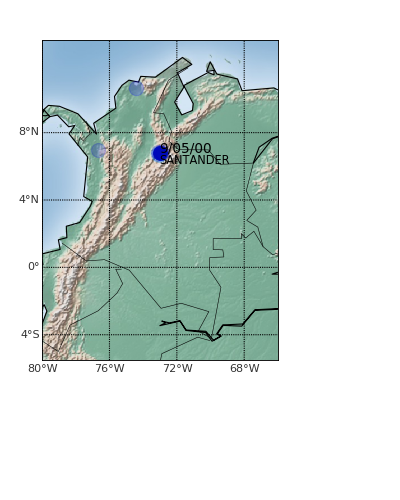

/home/eilin-luna/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/eilin-luna/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [12]:
# Area de graficacion.
fig=plt.figure(figsize=(4,5))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

mapa = Map(llcrnrlon=-80.,llcrnrlat=-5.5,
            urcrnrlon=-66,urcrnrlat=13.5,
            projection='cyl')

mapa.drawparallels(np.arange(-12, 12, 4),labels=[1,0,0,0], alpha=0.8)
mapa.drawmeridians(np.arange(-80, 80, 4),labels=[0,0,0,1], alpha=0.8)

mapa.shadedrelief()
mapa.drawcoastlines()
mapa.drawcountries()
       
# Objetos que se van a actualizar
punto,=ax.plot([],[])
dia = ax.text(0,0,'', color='k')
depart = ax.text(0,0,'', color='k')

#Inicializacion
def init():
    pass

#Animacion
nframes=len(sismos)
cmap=plt.get_cmap("jet")
def animacion(iframe):
    
    pos = sismos.index[iframe]
    
    x = sismos.qlon[pos]
    y = sismos.qlat[pos]
    r = sismos.Ml[pos]

    # Los colores dependen de la magnitud.
    color=cmap((r-nmin)/(nmax-nmin))
    
    #Asignamos los datos a los primitivos graficos de la animacion.
    dia.set_text(sismos.qdate[pos])
    dia.set_position([x,y])
    dia.set_fontsize(r*3)
    
    depart.set_text(sismos.departamento[pos])
    depart.set_position([x,y-0.7])
    depart.set_fontsize(r*2.5)
    
    punto.set_data(x,y)
    punto.set_color(color)
    punto.set_marker('o')
    punto.set_markersize(r*3)
    
    # Datos persistentes.
    x,y = mapa(x,y)
    mapa.plot(x,y,'o', ms=r*3, color=color,alpha=0.2)
 
    # Borramos los datos mas viejos.
    nlines=len(ax.lines)
    if nlines>18:ax.lines[12].remove()
    
anim=animation.FuncAnimation(fig,animacion, frames=nframes,
                             init_func=init,repeat=False,blit=True)

In [13]:
anim.save('Figura2.gif', dpi=60, writer='imagemagick')

/home/eilin-luna/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/eilin-luna/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


# 3. Magnitud y profundidad de los sismos.

<IPython.core.display.Javascript object>


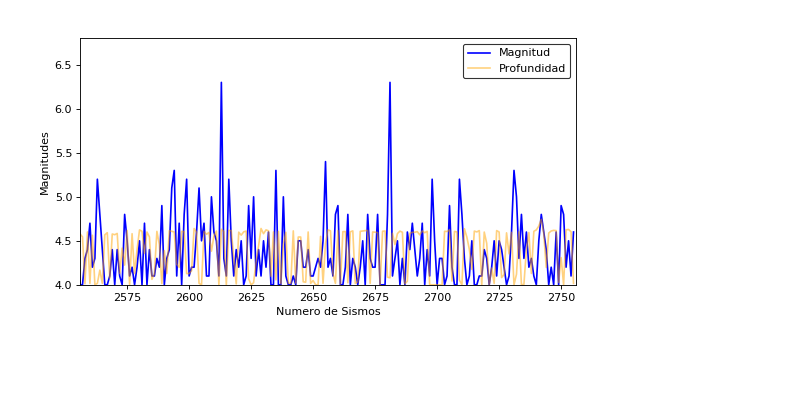

In [7]:
# Area de graficacion.
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
ax.patch.set_color('w')

ax.spines['bottom'].set_color('k')
ax.spines['top'].set_color('k')
ax.spines['right'].set_color('k')
ax.spines['left'].set_color('k')

ax.tick_params(axis='x', colors='k')
ax.tick_params(axis='y', colors='k')

ax.set_xlim((0,200))
ax.set_ylim((nmin,nmax))

mags,=ax.plot([],[], color='b', label='Magnitud')
profs,=ax.plot([],[], color='orange', alpha=0.5, label='Profundidad')

leg = ax.legend(loc=1, facecolor='w', edgecolor='k')
leg.get_texts()[0].set_color('k')
leg.get_texts()[1].set_color('k')

#Inicializacion
def init():
    ax.set_xlabel("Numero de Sismos", color='k')
    ax.set_ylabel("Magnitudes", color='k')

#Animacion
nframes=len(sismos)
def animacion(iframe):
    
    X = range(len(sismos))
    prof = sismos.qdepth.values*(nmax-nmin)/(pmax-pmin)+nmin
    profs.set_data(X[:iframe],prof[:iframe])
    
    mag = sismos.Ml.values
    mags.set_data(X[:iframe],mag[:iframe])
    
    if iframe>200:
        ax.set_xlim((iframe-200,iframe))
anim=animation.FuncAnimation(fig,animacion, frames=nframes,
                             init_func=init, repeat=False,blit=True)

In [8]:
anim.save('Figura3.gif', dpi=80, writer='imagemagick')